<a href="https://colab.research.google.com/github/SimgEsin/Genetik_Optimizasyonu_Seneryo8/blob/main/Proje1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YZ Vize Projesi: Sunucu Performans Optimizasyonu

**Adı:** Simge Esin
**Soyadı:** Çakal
**Okul Numarası:** 2312721028
**GitHub Repo Bağlantısı:** https://github.com/SimgEsin/Genetik_Optimizasyonu_Seneryo8

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Sabitler (Senaryo Gereği)
# x1: CPU (2-12 arası), x2: RAM (4-64 arası)
MIN_X1, MAX_X1 = 2, 12
MIN_X2, MAX_X2 = 4, 64

In [ ]:
# --- 1. PROBLEMİN TANIMI VE AMAÇ FONKSİYONU ---
def performans_hesapla(birey):
    """
    y = 5x₁ + 7x₂ - 0.1x₁² - 0.2x₂²
    Bu fonksiyon sunucunun performans skorunu hesaplar.
    """
    x1 = birey[0] # CPU
    x2 = birey[1] # RAM

    skor = (5 * x1) + (7 * x2) - (0.1 * x1**2) - (0.2 * x2**2)
    return skor

def kisit_kontrol(birey):
    """
    Senaryodaki kısıtları kontrol eder.
    Her ihlal için ceza puanı döndürür.
    """
    x1 = birey[0]
    x2 = birey[1]
    ceza = 0

    # Kısıt 1: x1 * x2 <= 512
    if (x1 * x2) > 512:
        ceza += 50 # Ciddi bir ceza

    # Kısıt 2: x1 >= 4 (CPU en az 4 olmalı)
    if x1 < 4:
        ceza += 50

    # Ekstra: Değişkenlerin sınır dışına çıkmaması için kontrol
    if not (MIN_X1 <= x1 <= MAX_X1) or not (MIN_X2 <= x2 <= MAX_X2):
        ceza += 50

    return ceza

def uygunluk_hesapla(birey):
    """
    Fitness = Performans Skoru - Cezalar
    Amacımız bu değeri maksimize etmek.
    """
    skor = performans_hesapla(birey)
    ceza = kisit_kontrol(birey)

    # Eğer ceza çok büyükse fitness negatif olabilir, bunu engellemiyoruz
    # çünkü genetik algoritma iyiyi seçecektir.
    return skor - ceza

# --- 2. GENETİK İŞLEMLER (HOCANIN KOD YAPISIYLA AYNI) ---

def rulet_secimi(populasyon, uygunluklar, adet=2):
    """Hocanın koduyla aynı mantık: İyilerin seçilme şansı artar."""
    # Negatif uygunlukları pozitife çevirmek için kaydırma işlemi (Rulet negatifle çalışmaz)
    min_uygunluk = np.min(uygunluklar)
    if min_uygunluk < 0:
        pozitif_uygunluklar = uygunluklar - min_uygunluk + 1
    else:
        pozitif_uygunluklar = uygunluklar + 1e-6 # Sıfıra bölme hatasını önlemek için

    toplam = np.sum(pozitif_uygunluklar)
    olasiliklar = pozitif_uygunluklar / toplam
    secilen_indeksler = np.random.choice(len(populasyon), size=adet, p=olasiliklar)
    return populasyon[secilen_indeksler]

def caprazlama(p1, p2):
    """
    Tek noktalı çaprazlama.
    Bizim sadece 2 genimiz (CPU, RAM) olduğu için
    yer değiştirme işlemi yapar.
    """
    # Rastgele bir noktadan böl (Bizde zaten 2 gen var, 1. noktadan böleceğiz)
    # p1'in CPU'su ile p2'nin RAM'ini birleştirir.
    c1 = np.array([p1[0], p2[1]])
    c2 = np.array([p2[0], p1[1]])
    return c1, c2

def mutasyon(birey, ihtimal, buyukluk):
    """
    Genlere rastgele küçük eklemeler/çıkarmalar yapar.
    """
    yeni_birey = birey.copy()
    for i in range(len(yeni_birey)):
        if np.random.rand() < ihtimal:
            # Rastgele değişim ekle
            degisim = buyukluk * (np.random.rand() - 0.5) * 10 # Etkiyi biraz artırdık
            yeni_birey[i] += degisim

            # Sınırları aşarsa düzelt (Clamping)
            if i == 0: # CPU
                yeni_birey[i] = np.clip(yeni_birey[i], MIN_X1, MAX_X1)
            else: # RAM
                yeni_birey[i] = np.clip(yeni_birey[i], MIN_X2, MAX_X2)

    return yeni_birey

🚀 Genetik Algoritma Başlatılıyor...

Nesil 10: En İyi Skor = 106.78 | CPU: 12.0, RAM: 18.1
Nesil 20: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6
Nesil 30: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6
Nesil 40: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6
Nesil 50: En İyi Skor = 106.85 | CPU: 12.0, RAM: 17.6

🏆 OPTİMİZASYON TAMAMLANDI
En İyi CPU Değeri: 12.00 (Çekirdek)
En İyi RAM Değeri: 17.57 (GB)
Maksimum Performans Skoru: 106.85


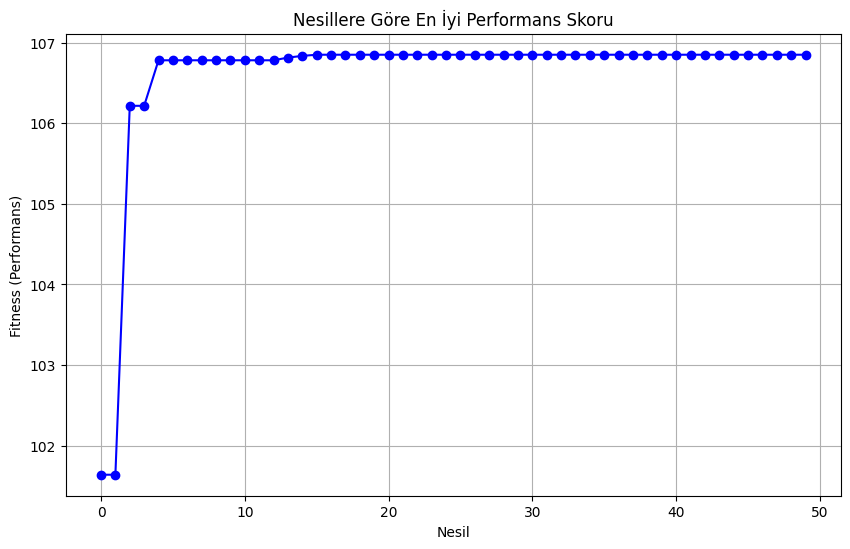

In [ ]:
# --- 3. ALGORİTMAYI ÇALIŞTIRMA (MAIN) ---

# Parametreler
POPULASYON_BOYUTU = 20
NESIL_SAYISI = 50
MUTASYON_IHTIMALI = 0.2
MUTASYON_BUYUKLUGU = 0.5

# Başlangıç Popülasyonunu Rastgele Oluştur
# [CPU, RAM] formatında rastgele bireyler
populasyon = []
for _ in range(POPULASYON_BOYUTU):
    cpu = random.uniform(MIN_X1, MAX_X1)
    ram = random.uniform(MIN_X2, MAX_X2)
    populasyon.append(np.array([cpu, ram]))

populasyon = np.array(populasyon)
en_iyi_skorlar = []

print("🚀 Genetik Algoritma Başlatılıyor...\n")

for nesil in range(NESIL_SAYISI):
    # 1. Her bireyin uygunluğunu hesapla
    uygunluklar = np.array([uygunluk_hesapla(b) for b in populasyon])

    # 2. En iyiyi bul ve sakla (Elitizm)
    en_iyi_indeks = np.argmax(uygunluklar)
    elit_birey = populasyon[en_iyi_indeks].copy()
    en_iyi_skor = uygunluklar[en_iyi_indeks]
    en_iyi_skorlar.append(en_iyi_skor)

    # 3. Yeni nesil oluşturma
    yeni_populasyon = [elit_birey] # Elit bireyi doğrudan aktar

    while len(yeni_populasyon) < POPULASYON_BOYUTU:
        # Seçim
        ebeveynler = rulet_secimi(populasyon, uygunluklar)
        p1, p2 = ebeveynler[0], ebeveynler[1]

        # Çaprazlama
        c1, c2 = caprazlama(p1, p2)

        # Mutasyon
        c1 = mutasyon(c1, MUTASYON_IHTIMALI, MUTASYON_BUYUKLUGU)
        c2 = mutasyon(c2, MUTASYON_IHTIMALI, MUTASYON_BUYUKLUGU)

        yeni_populasyon.extend([c1, c2])

    # Fazlalığı at ve popülasyonu güncelle
    populasyon = np.array(yeni_populasyon[:POPULASYON_BOYUTU])

    # Her 10 nesilde bir bilgi ver
    if (nesil+1) % 10 == 0:
        print(f"Nesil {nesil+1}: En İyi Skor = {en_iyi_skor:.2f} | CPU: {elit_birey[0]:.1f}, RAM: {elit_birey[1]:.1f}")

# --- SONUÇLARIN GÖRSELLEŞTİRİLMESİ ---
print("\n🏆 OPTİMİZASYON TAMAMLANDI")
print(f"En İyi CPU Değeri: {elit_birey[0]:.2f} (Çekirdek)")
print(f"En İyi RAM Değeri: {elit_birey[1]:.2f} (GB)")
print(f"Maksimum Performans Skoru: {en_iyi_skor:.2f}")

# Grafik
plt.figure(figsize=(10, 6))
plt.plot(en_iyi_skorlar, marker='o', color='b', linestyle='-')
plt.title("Nesillere Göre En İyi Performans Skoru")
plt.xlabel("Nesil")
plt.ylabel("Fitness (Performans)")
plt.grid(True)
plt.show()

# 🖥️ Sunucu Performans Optimizasyonu - Genetik Algoritma

Bu proje, bir sunucunun CPU ve RAM kaynaklarını optimize ederek maksimum performans skoruna ulaşmayı hedefler. Genetik Algoritma (GA) kullanılarak, belirlenen kısıtlar altında en iyi donanım konfigürasyonu bulunur.

## 📌 Problem Tanımı
Bir yazılım şirketi için aşağıdaki amaç fonksiyonuna göre sunucu ayarları optimize edilmektedir:

**Amaç Fonksiyonu:** `y = 5x₁ + 7x₂ - 0.1x₁² - 0.2x₂²`

**Değişkenler:**
- `x₁` (CPU Çekirdeği): [2, 12] aralığında.
- `x₂` (RAM Miktarı): [4, 64] aralığında.

**Kısıtlar:**
1. `x₁ * x₂ ≤ 512` (Kaynak çarpımı sınırı)
2. `x₁ ≥ 4` (Minimum 4 çekirdek gerekli)

## 🧬 Algoritma Yapısı
Proje Python kullanılarak geliştirilmiş ve aşağıdaki genetik operatörleri içerir:

1. **Başlangıç:** Belirlenen aralıklarda rastgele `[CPU, RAM]` popülasyonu oluşturulur.
2. **Uygunluk (Fitness):** Amaç fonksiyonundan elde edilen skor hesaplanır. Kısıtları ihlal eden bireylere ceza puanı uygulanarak skor düşürülür.
3. **Seçim (Selection):** Rulet tekerleği yöntemi ile performansı yüksek bireylerin seçilme şansı artırılır.
4. **Çaprazlama (Crossover):** Seçilen ebeveynlerin genleri karıştırılarak yeni bireyler üretilir.
5. **Mutasyon:** Rastgele oranlarda gen değerleri değiştirilerek çeşitlilik sağlanır ve yerel minimumdan kaçınılır.

## 📊 Sonuçlar
Algoritma çalıştırıldığında, nesiller ilerledikçe performans skorunun arttığı ve optimum CPU/RAM değerlerine yakınsadığı gözlemlenmiştir.


